In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tstrippy
from astropy import units as u
from astropy import coordinates as coord
import matplotlib as mpl
import tidalDebrisPhaseMixing as TDPM
mpl.rcParams['text.usetex'] = True

## Pick a random cluster. In one case, show it phase mix without self gravity, in another case turn gravity on 

In [2]:
# parameters to pick 
NP=int(1e2)
GCname = "NGC5139"
# laod data
clusters=tstrippy.Parsers.baumgardtMWGCs()
mean,cov=clusters.getGCCovarianceMatrix(GCname)
RA,DEC,Rsun,RV,mualpha,mu_delta,Mass,rh_m=mean
MWparams = tstrippy.Parsers.pouliasis2017pii()

In [3]:
# put the cluster in the MW 
skycoords=coord.sky_coordinate.SkyCoord(
    ra = RA * u.deg,
    dec = DEC * u.deg,
    distance = Rsun * u.kpc,
    radial_velocity = RV * u.km / u.s,
    pm_ra_cosdec = mualpha * u.mas / u.yr,
    pm_dec = mu_delta * u.mas / u.yr,)
galactocentric=skycoords.transform_to(coord.Galactocentric)

In [4]:
# estimate the dynamical time 
ax,ay,az,_ = tstrippy.potentials.pouliasis2017pii(MWparams,galactocentric.x.to(u.kpc).value,
                                                galactocentric.y.to(u.kpc).value,
                                                galactocentric.z.to(u.kpc).value)
gradPhi = np.sqrt(ax**2 + ay**2 + az**2)
r_gal = np.sqrt(galactocentric.x.to(u.kpc).value**2 +
                galactocentric.y.to(u.kpc).value**2 +
                galactocentric.z.to(u.kpc).value**2)
t_dyn = (1/2) * np.sqrt(r_gal / gradPhi[0])
print("dynamical time", t_dyn*np.pi*2, "Gyr")


dynamical time 0.08901507188023168 Gyr


In [5]:
# get the crossing time within the cluster
G = MWparams[0]
tcross = np.sqrt(rh_m**3/(G*Mass))
dt = tcross/100
integration_time = 1
NSTEP  = int(integration_time/dt)
integrationparamsCluster = [0,dt,NSTEP]
print("Integration time = ", integration_time, "Gyr")
print("Crossing time = ", tcross*1e6, "Myr")
print("NSTEP", NSTEP)
print("dt = ", dt*1e9, "years")

Integration time =  1 Gyr
Crossing time =  258.3883467157559 Myr
NSTEP 387014
dt =  2583.883467157559 years


In [6]:
# INTEGRATE THE HOST GLOBULAR CLUSTER
initialkinematics = [galactocentric.x.to(u.kpc).value,
                     galactocentric.y.to(u.kpc).value,
                     galactocentric.z.to(u.kpc).value,
                     galactocentric.v_x.to(u.km/u.s).value,
                     galactocentric.v_y.to(u.km/u.s).value,
                     galactocentric.v_z.to(u.km/u.s).value]
staticgalaxy = ["pouliasis2017pii",MWparams]
# let's see how this goes in any case 
# start the integration 
tstrippy.integrator.deallocate()
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
tstrippy.integrator.setintegrationparameters(*integrationparamsCluster)
tstrippy.integrator.setbackwardorbit()
xtGC,ytGC,ztGC,vxtGC,vytGC,vztGC=tstrippy.integrator.leapfrogintime(NSTEP,1)
timestamps = tstrippy.integrator.timestamps.copy() 
tstrippy.integrator.deallocate()                    
# flip everything 
xtGC = xtGC[0,::-1]
ytGC = ytGC[0,::-1]
ztGC = ztGC[0,::-1]
vxtGC = -vxtGC[0,::-1]
vytGC = -vytGC[0,::-1]
vztGC = -vztGC[0,::-1]
timestamps = timestamps[::-1]

In [7]:
# extract the cluster's initial conditions 
x0,y0,z0 = xtGC[0],ytGC[0],ztGC[0]
vx0,vy0,vz0 = vxtGC[0],vytGC[0],vztGC[0]
# create a plummer sphere
rplum=tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(rh_m)
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(MWparams[0],Mass,rh_m,NP)
# place the particles in the cluster's frame
xpp,ypp,zpp,vxpp,vypp,vzpp = xp+x0,yp+y0,zp+z0,vxp+vx0,vyp+vy0,vzp+vz0

In [8]:
# measure the distribution of energy of all the particles 
T = 0.5 * (vxpp**2 + vypp**2 + vzpp**2)
_,_,_,U = tstrippy.potentials.pouliasis2017pii(MWparams,xpp,ypp,zpp)
E = T + U
dE = 2*np.std(E)
meanE = np.mean(E)
print(dE)
# dE = np.min(E) - np.max(E)
print(dE)
mixingtime = 2*np.pi*t_dyn*np.abs(meanE/(3*dE))
print("estimate the miximg time ",mixingtime, "Gyr")


3284.8216955238377
3284.8216955238377
estimate the miximg time  1.6279518710201153 Gyr


In [11]:
import multiprocessing as mp
# integrate the particles in batches
ncpu = mp.cpu_count() - 2 
nbatches = ncpu
batchsize = int(NP/nbatches)

print("Using ", ncpu, "CPUs")
batches = []
for i in range(nbatches):
    start = i * batchsize
    end = (i + 1) * batchsize
    if i == nbatches - 1:
        end = NP  # last batch may be smaller
    batch_kinematics = [
        xpp[start:end], ypp[start:end], zpp[start:end],
        vxpp[start:end], vyp[start:end], vzpp[start:end]
    ]
    batches.append(batch_kinematics)

arg_list = [
    (staticgalaxy, integrationparamsCluster, batch_kinematics, [timestamps, xtGC, ytGC, ztGC, vxtGC, vytGC, vztGC, Mass, rplum])
    for batch_kinematics in batches
]

with mp.Pool(ncpu) as pool:
    results = pool.starmap(TDPM.integrate_particles, arg_list)
    print("Finished integrating batches")

Using  6 CPUs
Finished integrating batches


In [34]:
# stack the results
xt, yt, zt, vxt, vyt, vzt = np.zeros((NP,NSTEP+1)), np.zeros((NP,NSTEP+1)), np.zeros((NP,NSTEP+1)), np.zeros((NP,NSTEP+1)), np.zeros((NP,NSTEP+1)), np.zeros((NP,NSTEP+1))

for i in range(len(results)):
    start = i * batchsize
    end = (i + 1) * batchsize 
    if i == nbatches - 1:
        end = NP    
    xt[start:end, :] = results[i][0]
    yt[start:end, :] = results[i][1]
    zt[start:end, :] = results[i][2]
    vxt[start:end, :] = results[i][3]
    vyt[start:end, :] = results[i][4]
    vzt[start:end, :] = results[i][5]

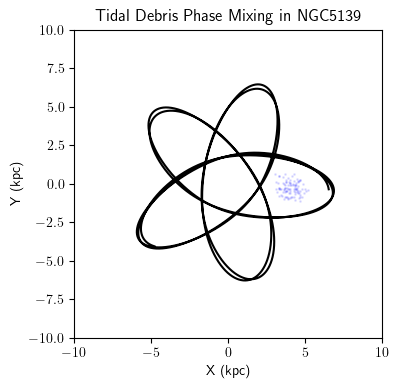

In [57]:
fig,axis=plt.subplots(1, 1, figsize=(4, 4))
axis.set_title("Tidal Debris Phase Mixing in " + GCname)
axis.set_xlabel("X (kpc)")
axis.set_ylabel("Y (kpc)")
axis.set_xlim(-10, 10)
axis.set_ylim(-10, 10)
axis.set_aspect('equal', adjustable='box')
axis.plot(xtGC, ytGC, color='black', label='Host GC Orbit')
index = 10000
for i in range(len(results)):
    axis.scatter(results[i][1][:, index], results[i][2][:, index], s=1,color='blue', alpha=0.1)

